# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter
import pickle 
import glob
import shutil
import os
import requests
import shutil
import urllib

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import imread, imshow, subplots, show
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

import pylab as pl

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim

from os import listdir
from os.path import isfile, join

from tqdm.auto import tqdm
import os
from PIL import Image
import cv2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# Preprocessing

In [2]:
data_path = '/root/User/_DIPLOMA/data/data_tbl_cvr_oscr_kws_small.csv'

df = pd.read_csv(data_path, index_col=0)

In [3]:
df.shape

(8784, 1037)

In [4]:
df.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [5]:
df.columns[-15:]

Index(['чета', 'зебра', 'сидень', 'беатрис', 'рыбка', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'poster_url', 'poster_url_preview'],
      dtype='object')

Get rid of keywords

In [6]:
df_cols = ['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'poster_url', 'poster_url_preview']

In [7]:
df = df[df_cols]

In [8]:
len(df['poster_url_preview'].unique())

8699

In [9]:
# add names of imgs

def add_img_name(data):
  return data.split('/')[-1]

df['img_name'] = df['poster_url_preview'].apply(add_img_name)

df.head().T[-5:]

,0,1,2,3,4
has_oscar_producer,0,0,0,0,0
has_oscar_writer,0,0,0,0,0
poster_url,https://kinopoiskapiunofficial.tech/images/posters/kp/6580.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp/6460.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp/1228112.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp/623934.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp/1172958.jpg
poster_url_preview,https://kinopoiskapiunofficial.tech/images/posters/kp_small/6580.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/6460.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/1228112.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/623934.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/1172958.jpg
img_name,6580.jpg,6460.jpg,1228112.jpg,623934.jpg,1172958.jpg


In [10]:
import ast

columns = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
                      'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
for col in columns:
  df[col] = df[col].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else np.nan)

In [11]:
cols_na = ['ACTOR', 'COMPOSER',
                 'DESIGN', 'DIRECTOR', 
                 'EDITOR', 'OPERATOR', 
                 'PRODUCER', 'WRITER']

df.dropna(subset=cols_na, inplace=True)

In [12]:
def add_topN_feature(df, col, n: int):
    items = []
    
    for i in df[col]:
        items.extend(i)

    topN = [x[0] for x in Counter(items).most_common()][:n]
    df[f'top{n}{col}'] = df[col].apply(lambda x: [int(item in x) for item in topN])
    df.drop(col, axis=1, inplace=True)
    return topN, f'top{n}{col}'

def ohe_topN_features(df, topN, cat):
    for i in range(len(topN)):
        df[f'{topN[i]}'] = [item[i] for item in df[cat]]
    df.drop(cat, axis=1, inplace=True)
    return df

In [13]:
top10genres, name = add_topN_feature(df, 'genre', 10)
df = ohe_topN_features(df, top10genres, name)

top10actors, name = add_topN_feature(df, 'ACTOR', 10)
df = ohe_topN_features(df, top10actors, name)

top3directors, name = add_topN_feature(df, 'COMPOSER', 3)
df = ohe_topN_features(df, top3directors, name)

top5countries, name = add_topN_feature(df, 'country', 5)
df = ohe_topN_features(df, top5countries, name)

top2DESIGN, name = add_topN_feature(df, 'DESIGN', 2)
df = ohe_topN_features(df, top2DESIGN, name)

top2DIRECTOR, name = add_topN_feature(df, 'DIRECTOR', 2)
df = ohe_topN_features(df, top2DIRECTOR, name)

top2EDITOR, name = add_topN_feature(df, 'EDITOR', 2)
df = ohe_topN_features(df, top2EDITOR, name)

top2OPERATOR, name = add_topN_feature(df, 'OPERATOR', 2)
df = ohe_topN_features(df, top2OPERATOR, name)

top3PRODUCER, name = add_topN_feature(df, 'PRODUCER', 3)
df = ohe_topN_features(df, top3PRODUCER, name)

top2WRITER, name = add_topN_feature(df, 'WRITER', 2)
df = ohe_topN_features(df, top2WRITER, name)

df.head().T

,0,1,4,5,6
age_access_type,12,16,6,16,12
name,Звёздный путь 5: Последний рубеж,Звёздный путь 6: Неоткрытая страна,Пламенное сердце,Роман с кукушкой,Звёздный путь 2: Гнев Хана
director,['cff3362f-ad91-498d-80b3-ea3ab8ec65cf'],['bab6b7f4-4506-458f-9091-d567505674f2'],"['40f78e6d-3c9f-434f-a505-c6ffdd045763', '332105c2-2697-49fd-97b2-b5022577758c']",['f5fba6fe-94b3-4e69-acfc-da6867320386'],['bab6b7f4-4506-458f-9091-d567505674f2']
average_rating,6.21,7.2,6.4,NaN,7.45
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE
...,...,...,...,...,...
Харви Вайнштейн,0,0,0,0,0
Боб Вайнштейн,0,0,0,0,0
Арнон Милчен,0,0,0,0,0
Люк Бессон,0,0,0,0,0


In [14]:
prep_df = df.copy(deep=True)

In [15]:
skewed_num_features = ['duration', 'BUDGET', 'MARKETING',
                       'RUS', 'USA', 'WORLD']

In [16]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

class Preprocesser:
    def __init__(self, 
#                 mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
#                 mltpl_cat_n_top: dict
                ):
#         self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
#         self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
#         df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [17]:
preprocesser = Preprocesser(
#     mltpl_cat_features,
            skewed_num_features,
            #text_features,
#             mltpl_cat_n_top
                           )

In [18]:
df_pr = preprocesser.preprocess(prep_df)

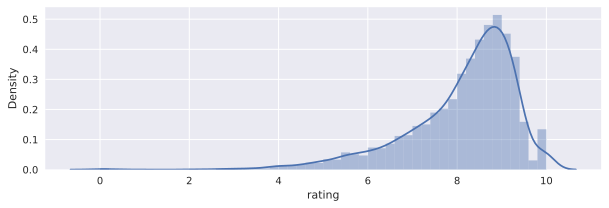

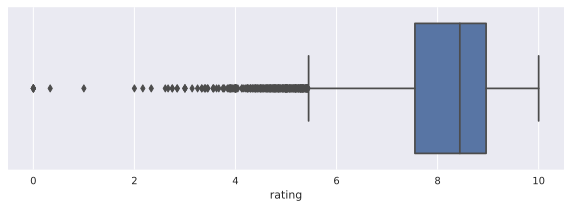

In [19]:
plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

### Test/Train split

In [20]:
train_df = df[df['release_year'] != 2022]

In [21]:
train_df.shape

(5785, 69)

In [22]:
train_df.dropna(subset=['rating'], inplace=True)
train_df.shape

(5785, 69)

In [23]:
test_df = df[df['release_year'] == 2022]
test_df.shape

(68, 69)

In [24]:
test_df.dropna(subset=['rating'], inplace=True)
test_df.shape

(68, 69)

### Preproc

In [25]:
train = train_df.copy(deep=True)
test = test_df.copy(deep=True)

In [26]:
train = train[train['release_year'] >= 2000]

In [27]:
train.shape

(4752, 69)

In [28]:
drop_cols = ['name', 'director', 'average_rating', 'release_type', 'release_year', 'actor',
             'element_uid', 'element_id', 'poster_url', 'poster_url_preview']

In [29]:
train.drop(drop_cols, axis=1, inplace=True)

test.drop(drop_cols, axis=1, inplace=True)

In [30]:
train.shape, test.shape

((4752, 59), (68, 59))

In [31]:
#  ohe: age_access_type, type
# standart sc: duration, BUDGET, MARKETING, RUS, USA, WORLD
# drop: 

In [32]:
# ohe
from sklearn.preprocessing import OneHotEncoder

ohe_cols = ['age_access_type', 'type']

oenc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_train = oenc.fit_transform(train[ohe_cols])

# enc_train = enc_train.toarray()

enc_train = pd.DataFrame(enc_train,columns=oenc.get_feature_names())

train = pd.concat([train, enc_train],axis=1)

train.drop(ohe_cols, axis=1, inplace=True)
# 
enc_test = oenc.transform(test[ohe_cols])

# enc_test= enc_test.toarray()

enc_test = pd.DataFrame(enc_test,columns=oenc.get_feature_names())

test = pd.concat([test, enc_test],axis=1) 

test.drop(ohe_cols, axis=1, inplace=True)

In [33]:
train.head().T[-50:]

,5,11,16,19,20
img_name,1038800.jpg,255129.jpg,734349.jpg,321.jpg,455165.jpg
Drama,1.0,0.0,0.0,0.0,0.0
Comedy,1.0,0.0,0.0,0.0,0.0
Thriller,0.0,1.0,1.0,1.0,0.0
Action,0.0,1.0,1.0,1.0,1.0
364fdc2e-bdfe-40be-b2c5-d30f43ec432e,0.0,0.0,0.0,0.0,0.0
Adventure,0.0,1.0,0.0,1.0,1.0
Sci-Fi,0.0,1.0,1.0,1.0,1.0
Melodrama,1.0,0.0,0.0,0.0,0.0
Horror,0.0,0.0,0.0,0.0,0.0


In [34]:
train.shape, test.shape

((6447, 65), (133, 65))

### Standartization

In [35]:
# sc
from sklearn.preprocessing import StandardScaler

sc_cols = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']

sc=StandardScaler()
sc_train = sc.fit_transform(train[sc_cols])

sc_train = pd.DataFrame(sc_train,columns=sc_cols)
train.drop(sc_cols, axis=1, inplace=True)
train = pd.concat([train, sc_train],axis=1)

# 
sc_test = sc.transform(test[sc_cols])

sc_test = pd.DataFrame(sc_test,columns=sc_cols)
test.drop(sc_cols, axis=1, inplace=True)

test = pd.concat([test, sc_test],axis=1) 



In [36]:
train.head().T[-50:]

,5,11,16,19,20
Adventure,0.0,1.0,0.0,1.0,1.0
Sci-Fi,0.0,1.0,1.0,1.0,1.0
Melodrama,1.0,0.0,0.0,0.0,0.0
Horror,0.0,0.0,0.0,0.0,0.0
9fa28b61-a257-4a3e-945b-a9ef76a146d6,0.0,0.0,0.0,0.0,0.0
Бернард Коллако,0.0,0.0,0.0,0.0,0.0
Марк Фальво,0.0,0.0,0.0,0.0,0.0
Джимми Стар,0.0,0.0,0.0,0.0,0.0
Брюс Уиллис,0.0,0.0,0.0,0.0,0.0
Роджер Бреннер,0.0,0.0,0.0,0.0,0.0


In [37]:
fls = None 
for root_dir, cur_dir, files in os.walk(r'/root/User/_DIPLOMA/data/train_covers/'):
    fls = files
    
len(fls)

7892

In [38]:
print(train.shape)
train_pr = train[train['img_name'].isin(fls)]
train_pr.shape

(7270, 65)


(4658, 65)

In [39]:
tst_fls = None 
for root_dir, cur_dir, files in os.walk(r'/root/User/_DIPLOMA/data/test_covers/'):
    tst_fls = files

In [40]:
len(tst_fls)

97

In [41]:
print(test.shape)
test_pr = test[test['img_name'].isin(tst_fls)]
test_pr.shape

(198, 65)


(47, 65)

**Save preproc dfs**

In [42]:
# 

# with open('/root/User/_DIPLOMA/data/preproc_dfs/train_pr_oscr_ohe.pkl', 'wb') as f:
#     pickle.dump(train_pr, f)

# with open('/root/User/_DIPLOMA/data/preproc_dfs/test_pr_oscr_ohe.pkl', 'wb') as f:
#     pickle.dump(test_pr, f)

**Load datasets**

In [43]:
with open('/root/User/_DIPLOMA/data/preproc_dfs/train_pr_oscr_ohe.pkl', 'rb') as f:
    train_pr = pickle.load(f, encoding='utf-8')

In [44]:
with open('/root/User/_DIPLOMA/data/preproc_dfs/test_pr_oscr_ohe.pkl', 'rb') as f:
    test_pr = pickle.load(f, encoding='utf-8')

In [45]:
test_pr.head().T

,4,13,46,1020,2836
rating,9.282869,8.9459,8.626496,5.504337,9.417652
has_oscar_actor,0.0,0.0,0.0,0.0,0.0
has_oscar_composer,0.0,0.0,0.0,0.0,0.0
has_oscar_design,0.0,0.0,0.0,0.0,0.0
has_oscar_director,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
BUDGET,NaN,NaN,NaN,NaN,NaN
MARKETING,NaN,NaN,NaN,NaN,NaN
RUS,0.129165,NaN,NaN,NaN,NaN
USA,0.171812,NaN,NaN,NaN,NaN


In [46]:
test_pr.columns

Index(['rating', 'has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'img_name', 'Drama', 'Comedy',
       'Thriller', 'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e',
       'Adventure', 'Sci-Fi', 'Melodrama', 'Horror',
       '9fa28b61-a257-4a3e-945b-a9ef76a146d6', 'Бернард Коллако',
       'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис', 'Роджер Бреннер',
       'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс', 'Кадролша Она Кароле',
       'Дэнни Трехо', 'Джон Дебни', 'Джеймс Ньютон Ховард', 'Марко Белтрами',
       'usa', 'great-britain', 'france', 'germany', 'canada', 'Эллен Мирожник',
       'Энн Рот', 'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'x0_0', 'x0_6', 'x0_12',
       'x0_16', 'x0_18', 'x1_MOVIE', 'x1_MP_MOVIE', 

In [47]:
train_pr.isna().sum()[50:100]

Стэн Ли           0
x0_0           1641
x0_6           1641
x0_12          1641
x0_16          1641
x0_18          1641
x1_MOVIE       1641
x1_MP_MOVIE    1641
x1_SERIAL      1641
duration       1641
BUDGET         3255
MARKETING      4511
RUS            3089
USA            3018
WORLD          2439
dtype: int64

In [48]:
train_new = train_pr.drop([
'x0_0',
'x0_6',
'x0_12',
'x0_16',
'x0_18',
'x1_MOVIE',
'x1_MP_MOVIE',
'x1_SERIAL',
'duration' ,
'BUDGET',
'MARKETING',
'RUS' ,
'USA' ,
'WORLD'], axis=1)

test_new = test_pr.drop([
'x0_0',
'x0_6',
'x0_12',
'x0_16',
'x0_18',
'x1_MOVIE',
'x1_MP_MOVIE',
'x1_SERIAL',
'duration' ,
'BUDGET',
'MARKETING',
'RUS' ,
'USA' ,
'WORLD'], axis=1)

# PyTorch

In [49]:
!pip install pytorch_lightning #==1.5

In [50]:
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


data_path = "./data/"

In [51]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.tabular = df 

    def __len__(self):
        return self.tabular.shape[0]

    def __getitem__(self, idx):
        tabular = self.tabular.iloc[idx, 0:]

        y = tabular["rating"]

        image = Image.open(f"{self.image_dir}/{tabular['img_name']}")
        image = np.array(image)
        image = image[..., :3]

        image = transforms.functional.to_tensor(image)

        tabular = tabular[['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
                            'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
                            'has_oscar_producer', 'has_oscar_writer', 'Drama', 'Comedy',
                            'Thriller', 'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e',
                            'Adventure', 'Sci-Fi', 'Melodrama', 'Horror',
                            '9fa28b61-a257-4a3e-945b-a9ef76a146d6', 'Бернард Коллако',
                            'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис', 'Роджер Бреннер',
                            'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс', 'Кадролша Она Кароле',
                            'Дэнни Трехо', 'Джон Дебни', 'Джеймс Ньютон Ховард', 'Марко Белтрами',
                            'usa', 'great-britain', 'france', 'germany', 'canada', 'Эллен Мирожник',
                            'Энн Рот', 'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
                            'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
                            'Арнон Милчен', 'Люк Бессон', 'Стэн Ли']] # 'x0_0', 'x0_6', 'x0_12',
                            # 'x0_16', 'x0_18', 'x1_MOVIE', 'x1_MP_MOVIE', 'x1_SERIAL', 'duration',
                            # 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD'
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)

        return image, tabular, y

In [52]:
a = ['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
    'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
    'has_oscar_producer', 'has_oscar_writer', 'Drama', 'Comedy',
    'Thriller', 'Action', '364fdc2e-bdfe-40be-b2c5-d30f43ec432e',
    'Adventure', 'Sci-Fi', 'Melodrama', 'Horror',
    '9fa28b61-a257-4a3e-945b-a9ef76a146d6', 'Бернард Коллако',
    'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис', 'Роджер Бреннер',
    'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс', 'Кадролша Она Кароле',
    'Дэнни Трехо', 'Джон Дебни', 'Джеймс Ньютон Ховард', 'Марко Белтрами',
    'usa', 'great-britain', 'france', 'germany', 'canada', 'Эллен Мирожник',
    'Энн Рот', 'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
    'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
    'Арнон Милчен', 'Люк Бессон', 'Стэн Ли']

len(a)

49

## Model

In [53]:
test_new.isna().sum().sum()

0

In [54]:
image_data_train = ImageDataset(df=train_new, image_dir='/root/User/_DIPLOMA/data/train_covers')

test_set = ImageDataset(df=test_new, image_dir='/root/User/_DIPLOMA/data/test_covers')

train_set, test_dddd, val_set = random_split(image_data_train, [4000, 0, 658])
len(train_set), len(test_set), len(val_set)

(4000, 47, 658)

In [55]:
BATCH_SIZE = 16

In [56]:
train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)


#### **Architecture**

In [57]:
def conv_block(input_size, output_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, (3, 3)), 
        nn.ReLU(),
        nn.BatchNorm2d(output_size),
        nn.MaxPool2d((2, 2)),
    )

    return block

In [58]:
def accuracy(output,labels):
    _,preds =torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [110]:
# class RatingPredictor(nn.Module):
#     def __init__(
#         self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
#     ):
#         super().__init__()
#         self.lr = lr
#         self.num_workers = num_workers
#         self.batch_size = batch_size

#         self.conv1 = conv_block(3, 16)
#         self.conv2 = conv_block(16, 32)
#         self.conv3 = conv_block(32, 64)

#         self.ln1 = nn.Linear(64 * 6 * 6, 16)
#         self.relu = nn.ReLU()
#         self.batchnorm = nn.BatchNorm1d(16)
# #         self.dropout = nn.Dropout2d(0.5) ########
#         self.ln2 = nn.Linear(16, 5)

# #         self.ln4 = nn.Linear(49, 10)
#         self.ln4 = nn.Linear(49, 5)
# #         self.ln5 = nn.Linear(10, 10)
# #         self.ln6 = nn.Linear(10, 5)
#         self.ln7 = nn.Linear(10, 1)

#     def forward(self, img, tab):
#         img = self.conv1(img)
#         img = self.conv2(img)
#         img = self.conv3(img)

#         img = img.reshape(img.shape[0], -1)
#         img = self.ln1(img)
#         img = self.relu(img)
#         img = self.batchnorm(img)
# #         img = self.dropout(img)
#         img = self.ln2(img)
#         img = self.relu(img)
        
#         tab = self.ln4(tab)
#         tab = self.relu(tab)
# #         tab = self.ln5(tab)
# #         tab = self.relu(tab)
# #         tab = self.ln6(tab)
# #         tab = self.relu(tab)
       
#         x = torch.cat((img, tab), dim=1)
#         x = self.relu(x)

#         return self.ln7(x)
    
#     def training_step(self, batch):
#         inputs, tabular, targets = batch 
#         # Generate predictions
#         out = self(inputs, tabular)        
#         # Calcuate loss
#         loss = F.l1_loss(out, targets)                
#         return loss

#     def validation_step(self, batch):
#         inputs, tabular, targets = batch
#         # Generate predictions
#         out = self(inputs, tabular)
#         # Calculate loss
#         loss = F.l1_loss(out, targets) 
#         acc = accuracy(out,targets)                   
#         return {'val_loss': loss.detach(), 'val_acc':acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accuracy = [x['val_acc'] for x in outputs]
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
#     def epoch_end(self, epoch, result, num_epochs):
#         if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
#             print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))   

In [111]:
# class RatingPredictor(nn.Module):
#     def __init__(
#         self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
#     ):
#         super().__init__()
#         self.lr = lr
#         self.num_workers = num_workers
#         self.batch_size = batch_size

#         self.conv1 = conv_block(3, 16)
#         self.conv2 = conv_block(16, 32)
#         self.conv3 = conv_block(32, 64)

#         self.ln1 = nn.Linear(64 * 6 * 6, 16)
# #         self.ln1 = nn.Linear(98 * 4 * 4 * 4, 16)
#         self.relu = nn.ReLU()
#         self.batchnorm = nn.BatchNorm1d(16)  ####~
# #         self.dropout = nn.Dropout2d(0.5) ########
#         self.ln2 = nn.Linear(16, 5)

#         self.ln4 = nn.Linear(49, 10)
# #         self.ln5 = nn.Linear(10, 10)
#         self.ln6 = nn.Linear(10, 5)
#         self.ln7 = nn.Linear(10, 1)

#     def forward(self, img, tab):
#         img = self.conv1(img)

#         img = self.conv2(img)
#         img = self.conv3(img)
# #         print(f'img: {img.shape}')
#         img = img.reshape(img.shape[0], -1)
# #         print(f'img 2: {img.shape}')
#         img = self.ln1(img)
#         img = self.relu(img)
#         img = self.batchnorm(img)
# #         img = self.dropout(img)
#         img = self.ln2(img)
#         img = self.relu(img)
        
#         tab = self.ln4(tab)
#         tab = self.relu(tab)
# #         tab = self.ln5(tab)
# #         tab = self.relu(tab)
#         tab = self.ln6(tab)
#         tab = self.relu(tab)
       
#         x = torch.cat((img, tab), dim=1)
#         x = self.relu(x)

#         return self.ln7(x)
    
#     def training_step(self, batch):
#         inputs, tabular, targets = batch 
#         # Generate predictions
#         out = self(inputs, tabular)   
#         # print(f'OUT train: {out}')      
#         # Calcuate loss
#         loss = F.l1_loss(out, targets)                
#         return loss

#     def validation_step(self, batch):
#         inputs, tabular, targets = batch
#         # Generate predictions
#         out = self(inputs, tabular)
#         # Calculate loss
#         loss = F.l1_loss(out, targets) 
#         acc = accuracy(out,targets)                   
#         return {'val_loss': loss.detach(), 'val_acc':acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accuracy = [x['val_acc'] for x in outputs]
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
#     def epoch_end(self, epoch, result, num_epochs):
#         if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
#             print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [112]:
# class RatingPredictor(nn.Module):
#     def __init__(
#         self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
#     ):
#         super().__init__()
#         self.lr = lr
#         self.num_workers = num_workers
#         self.batch_size = batch_size

#         self.conv1 = conv_block(3, 16)
#         self.conv2 = conv_block(16, 32)
#         self.conv3 = conv_block(32, 64)

#         self.ln1 = nn.Linear(64 * 6 * 6, 16)
#         self.relu = nn.ReLU()
#         self.batchnorm = nn.BatchNorm1d(16)
#         self.dropout = nn.Dropout2d(0.5)
#         self.ln2 = nn.Linear(16, 5)

#         self.ln4 = nn.Linear(49, 10)
#         # self.ln4 = nn.Linear(63, 10)
#         self.ln5 = nn.Linear(10, 10)
#         self.ln6 = nn.Linear(10, 5)
#         self.ln7 = nn.Linear(10, 1)

#     def forward(self, img, tab):
#         img = self.conv1(img)

#         img = self.conv2(img)
#         img = self.conv3(img)
#         img = img.reshape(img.shape[0], -1)
#         img = self.ln1(img)
#         img = self.relu(img)
#         img = self.batchnorm(img)
#         img = self.dropout(img)
#         img = self.ln2(img)
#         img = self.relu(img)
#         # print(f'tab BEFORE: {tab}')
#         tab = self.ln4(tab)
#         tab = self.relu(tab)
#         tab = self.ln5(tab)
#         tab = self.relu(tab)
#         tab = self.ln6(tab)
#         tab = self.relu(tab)
       
#         x = torch.cat((img, tab), dim=1)
#         # print(f'X SHAPE: {x.shape}')
#         x = self.relu(x)

#         return self.ln7(x)
    
#     def training_step(self, batch):
#         inputs, tabular, targets = batch 
#         # Generate predictions
#         out = self(inputs, tabular)   
#         # print(f'OUT train: {out}')      
#         # Calcuate loss
#         loss = F.l1_loss(out, targets)                
#         return loss

#     def validation_step(self, batch):
#         inputs, tabular, targets = batch
#         # Generate predictions
#         out = self(inputs, tabular)
#         # Calculate loss
#         loss = F.l1_loss(out, targets) 
#         acc = accuracy(out,targets)                   
#         return {'val_loss': loss.detach(), 'val_acc':acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accuracy = [x['val_acc'] for x in outputs]
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
#     def epoch_end(self, epoch, result, num_epochs):
#       if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
#         print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [138]:
class RatingPredictor(nn.Module):
    def __init__(self, img_size=64,
                 hid_size1=10,
                 out_size=26,
                 conv_channels_1 = 20,
                 conv_channels_2 = 24,
                 conv_channels_3 = 32,
                 activ_func=nn.ReLU(),
                 conv_kernel_size=5,
                 stride_n=2, padding_n=0):
      
        super(RatingPredictor, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3,
                              out_channels=conv_channels_1,
                              kernel_size=conv_kernel_size,
                              stride=stride_n,
                              padding=padding_n) 
        self.af1 = activ_func
        
        self.do1 = nn.Dropout(.5)

        linear_input = (img_size + 2 * padding_n - conv_kernel_size) // stride_n + 1

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=conv_channels_1, 
                              out_channels=conv_channels_2, 
                              kernel_size=3,
                              stride=stride_n,
                              padding=padding_n) # 12-5+1 = 8
        self.af2 = activ_func
        self.do2 = nn.Dropout(.5)

        linear_input = (linear_input + 2 * padding_n - 3) // stride_n + 1

        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=conv_channels_2,
                              out_channels=conv_channels_3,
                              kernel_size=2,
                              stride=1,
                              padding=padding_n) # 8-5+1 = 4
        self.af3 = activ_func 
        linear_input = (linear_input + 2 * padding_n - 2) // 1 + 1
    
        # Fully connected 1
        self.fc1 = nn.Linear(linear_input * linear_input * conv_channels_3, hid_size1) 
        self.bn1 = nn.BatchNorm1d(hid_size1)
        self.af4 = activ_func 
        
        self.ln4 = nn.Linear(49, 10)
        self.af5 = activ_func 
#         self.ln5 = nn.Linear(150, 10)
        self.af6 = activ_func 
        self.ln7 = nn.Linear(20, 1)
    

    def forward(self, img, tab):
        # Convolution 1
        img = self.cnn1(img)
        img = self.af1(img)
        
        img = self.do1(img)

        # # Max pool 1
        # out = self.mp1(out)
        
        # Convolution 2 
        img = self.cnn2(img)
        img = self.af2(img)

        img = self.do2(img)
        # # Max pool 2
        # out = self.mp2(out)

        # Convolution 3
        img = self.cnn3(img)
        img = self.af3(img)

        # flatten
        img = img.view(img.size(0), -1)

        # Linear function 1
        img = self.fc1(img)
        img = self.bn1(img)
        img = self.af4(img)

        # Linear function 
        tab = self.ln4(tab)
        tab = self.af5(tab)
        x = torch.cat((img, tab), dim=1)
#         print(x.shape)
        x = self.af6(x)
        return self.ln7(x)
    
    def training_step(self, batch):
        inputs, tabular, targets = batch 
        # Generate predictions
        out = self(inputs, tabular)       
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss

    def validation_step(self, batch):
        inputs, tabular, targets = batch
        # Generate predictions
        out = self(inputs, tabular)
        # Calculate loss
        loss = F.l1_loss(out, targets) 
        acc = accuracy(out,targets)                   
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))   

In [139]:
# Create model
model_1 = RatingPredictor()

# L1 Loss 
error = nn.L1Loss()

# SGD Optimizer
learning_rate = 0.01 

# optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate)

In [140]:
def evaluate(model, val_loader):
    model.eval() #
    with torch.no_grad(): #
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):  # train
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)

    return history

In [141]:
history = [evaluate(model_1,val_loader)]
print(history)

[{'val_loss': 7.976522809740955, 'val_acc': 0.0029761905316263437}]


In [142]:
epochs = 2000

history += train(epochs, learning_rate, model_1, train_loader, val_loader)

Epoch [50], val_loss: 0.9215
Epoch [100], val_loss: 0.8998
Epoch [150], val_loss: 0.9023
Epoch [200], val_loss: 0.9112
Epoch [250], val_loss: 0.9327


KeyboardInterrupt: 

In [64]:
epochs = 2000

history += train(epochs, learning_rate, model_1, train_loader, val_loader)

Epoch [50], val_loss: 0.9063
Epoch [100], val_loss: 0.8891
Epoch [150], val_loss: 0.8868
Epoch [200], val_loss: 0.8814
Epoch [250], val_loss: 0.8921
Epoch [300], val_loss: 0.8618
Epoch [350], val_loss: 0.8738
Epoch [400], val_loss: 0.8640
Epoch [450], val_loss: 0.8722
Epoch [500], val_loss: 0.8593
Epoch [550], val_loss: 0.8737
Epoch [600], val_loss: 0.8725
Epoch [650], val_loss: 0.8652
Epoch [700], val_loss: 0.8599
Epoch [750], val_loss: 0.8713
Epoch [800], val_loss: 0.8575
Epoch [850], val_loss: 0.8564
Epoch [900], val_loss: 0.8629
Epoch [950], val_loss: 0.9003
Epoch [1000], val_loss: 0.8805
Epoch [1050], val_loss: 0.8715
Epoch [1100], val_loss: 0.8637
Epoch [1150], val_loss: 0.8712
Epoch [1200], val_loss: 0.8628
Epoch [1250], val_loss: 0.8717
Epoch [1300], val_loss: 0.8753
Epoch [1350], val_loss: 0.8992
Epoch [1400], val_loss: 0.8974
Epoch [1450], val_loss: 0.8712
Epoch [1500], val_loss: 0.8760
Epoch [1550], val_loss: 0.8949
Epoch [1600], val_loss: 0.8582
Epoch [1650], val_loss: 0.89

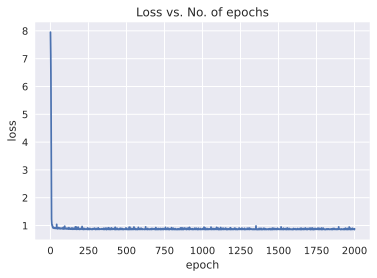

In [65]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

### Make Prediction 

In [66]:
test_imgs, test_tabular, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
    preds = model_1(test_imgs, test_tabular)

In [67]:
yhat=torch.max(preds.data,1)  # [1]
yhat[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [68]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = (mean_squared_error(y_true, y_pred))
    root_mean_squared_err = np.sqrt(mean_squared_err)
    mae = (mean_absolute_error(y_true, y_pred))
    r2 = round(r2_score(y_true, y_pred)*100,0)
    return mean_squared_err, root_mean_squared_err, mae, r2

In [69]:
test_mean_squared_error, test_root_mean_squared_error,test_mae, test_r2_score_percentage = calculate_errors_and_r2(test_lbls, yhat[1])

print('Test Data MSE = ', test_mean_squared_error)
print('Test Data RMSE = ', test_root_mean_squared_error)
print('Test Data MAE = ', test_mae)
print('Test Data R2 = ', test_r2_score_percentage)

Test Data MSE =  62.971365937118364
Test Data RMSE =  7.935449951774529
Test Data MAE =  7.794903250728922
Test Data R2 =  -2748.0


**Save model**

In [70]:
torch.save(model_1.state_dict(), '/root/User/_DIPLOMA/models_chp/model_1_900epoch.pth')

**Load model**

In [40]:
model_1_loaded = RatingPredictor()
model_1_loaded.load_state_dict(torch.load('/root/User/_DIPLOMA/models_chp/model_1_900ep.pth'))


<All keys matched successfully>

### LightningModule

In [ ]:
class LitClassifier(pl.LightningModule):
    def __init__(
        self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
    ):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.conv1 = conv_block(3, 16)
        self.conv2 = conv_block(16, 32)
        self.conv3 = conv_block(32, 64)

        self.ln1 = nn.Linear(64 * 6 * 6, 16)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout2d(0.5)
        self.ln2 = nn.Linear(16, 5)

        self.ln4 = nn.Linear(49, 10)
        self.ln5 = nn.Linear(10, 10)
        self.ln6 = nn.Linear(10, 5)
        self.ln7 = nn.Linear(10, 1)

    def forward(self, img, tab):
        img = self.conv1(img)

        img = self.conv2(img)
        img = self.conv3(img)
        img = img.reshape(img.shape[0], -1)
        img = self.ln1(img)
        img = self.relu(img)
        img = self.batchnorm(img)
        img = self.dropout(img)
        img = self.ln2(img)
        img = self.relu(img)

        tab = self.ln4(tab)
        tab = self.relu(tab)
        tab = self.ln5(tab)
        tab = self.relu(tab)
        tab = self.ln6(tab)
        tab = self.relu(tab)

        x = torch.cat((img, tab), dim=1)
        x = self.relu(x)

        return self.ln7(x)

    def training_step(self, batch, batch_idx):
        image, tabular, y = batch

        criterion = torch.nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        loss = criterion(y_pred, y)

        # tensorboard_logs = {"train_loss": loss}
        # return {"loss": loss, "log": tensorboard_logs}
        # print('>>> Loss:regression/train: ', loss)
        # rmse = torch.sqrt(loss)
        # print('>>> RMSE/train: ', rmse)
        return loss

    def validation_step(self, batch, batch_idx):
        image, tabular, y = batch

        criterion = torch.nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        val_loss = criterion(y_pred, y)
        
        # print('>>> Loss:regression/validation: ', val_loss)
        rmse = torch.sqrt(val_loss)
        # print('>>> RMSE/validation: ', rmse)
        return {"val_loss": val_loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        # tensorboard_logs = {"val_loss": avg_loss}
#         print(f'AVG VAL LOSS: {avg_loss}')
        # return {"val_loss": avg_loss, "log": tensorboard_logs}
        return {"val_loss": avg_loss}

    def test_step(self, batch, batch_idx):
        image, tabular, y = batch

        criterion = torch.nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        test_loss = criterion(y_pred, y)
        # print('>>> Test loss:', test_loss)
        # return {"test_loss": test_loss}
        # return test_loss

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        # logs = {"test_loss": avg_loss}
        # return {"test_loss": avg_loss, "log": logs, "progress_bar": logs}
        print(f'AVG TEST LOSS: {avg_loss}')
        return {"test_loss": avg_loss}
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr))
    
    def setup(self, stage):
    
        # train

        image_data_train = ImageDataset(df=train_new, image_dir='/root/User/_DIPLOMA/data/train_covers')

        self.test_set = ImageDataset(df=test_new, image_dir='/root/User/_DIPLOMA/data/test_covers')

        self.train_set, test_dddd, self.val_set = random_split(image_data_train, [4000, 0, 658])



    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="multi_input")

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")

In [ ]:
model = LitClassifier()

In [ ]:
trainer = pl.Trainer(default_root_dir="/root/User/_DIPLOMA/models_chp/checkpoint_ptl_model.ckpt") # , callbacks=early_stop_callback

In [ ]:
trainer.fit_loop.max_epochs=900

In [ ]:
lr_finder = trainer.tuner.lr_find(model)

In [ ]:
fig = lr_finder.plot(suggest=True, show=True)

In [ ]:
new_lr = lr_finder.suggestion()

In [ ]:
trainer.fit(model)

In [ ]:
trainer.test(model)


In [ ]:
def predict_dataloader(model, dataloader):
    predictions = []
    model.eval()
    for batch in dataloader:
        predictions.append(model(batch).detach().numpy())
    return np.vstack(predictions)

In [ ]:
predictions = predict_dataloader(model, test_loader)